In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
from transformers import ViTModel
from torch.optim import Adam
from PIL import Image
import numpy as np
import os
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. تعریف Dataset برای Triplet‌ها
# class TripletDataset(Dataset):
#     def __init__(self, dataset):
#         self.dataset = dataset
#         self.classes = dataset.classes
#         self.class_to_indices = {cls: np.where(np.array(dataset.targets) == idx)[0] for idx, cls in enumerate(self.classes)}
#         self.transform = Compose([
#             Resize((224, 224)),  # تغییر اندازه تصاویر به 224x224
#             ToTensor(),  # تبدیل تصاویر به تانسور
#             Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # نرمال‌سازی
#         ])

#     def __len__(self):
#         return len(self.dataset)

#     def __getitem__(self, idx):
#         anchor_path, anchor_label = self.dataset.samples[idx]  # مسیر فایل و برچسب

#         # انتخاب Positive (همان کلاس)
#         positive_idx = np.random.choice(self.class_to_indices[self.classes[anchor_label]])
#         positive_path, _ = self.dataset.samples[positive_idx]

#         # انتخاب Negative (کلاس متفاوت)
#         negative_label = np.random.choice([cls for cls in self.classes if cls != self.classes[anchor_label]])
#         negative_idx = np.random.choice(self.class_to_indices[negative_label])
#         negative_path, _ = self.dataset.samples[negative_idx]

#         # پیش‌پردازش تصاویر
#         anchor_image = self.transform(Image.open(anchor_path).convert("RGB"))
#         positive_image = self.transform(Image.open(positive_path).convert("RGB"))
#         negative_image = self.transform(Image.open(negative_path).convert("RGB"))

#         return anchor_image, positive_image, negative_image

class TripletDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.classes = dataset.classes
        self.class_to_indices = {cls: np.where(np.array(dataset.targets) == idx)[0] for idx, cls in enumerate(self.classes)}
        self.transform = Compose([
            Resize((224, 224)),  # تغییر اندازه تصاویر به 224x224
            ToTensor(),  # تبدیل تصاویر به تانسور
            Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # نرمال‌سازی
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        anchor_path, anchor_label = self.dataset.samples[idx]  # مسیر فایل و برچسب

        # انتخاب Positive (همان کلاس)
        positive_idx = np.random.choice(self.class_to_indices[self.classes[anchor_label]])
        positive_path, _ = self.dataset.samples[positive_idx]

        # انتخاب Negative (کلاس متفاوت)
        negative_label = np.random.choice([cls for cls in self.classes if cls != self.classes[anchor_label]])
        negative_idx = np.random.choice(self.class_to_indices[negative_label])
        negative_path, _ = self.dataset.samples[negative_idx]

        # پیش‌پردازش تصاویر
        anchor_image = self.transform(Image.open(anchor_path).convert("RGB"))
        positive_image = self.transform(Image.open(positive_path).convert("RGB"))
        negative_image = self.transform(Image.open(negative_path).convert("RGB"))

        # برچسب‌ها
        return anchor_image, positive_image, negative_image, anchor_label  # برچسب‌ها را هم باز می‌گردانیم


# 2. تعریف Attention Layer
class AttentionLayer(nn.Module):
    def __init__(self, feature_dim):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(feature_dim, feature_dim // 2),
            nn.ReLU(),
            nn.Linear(feature_dim // 2, 1),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        # x shape: (batch_size, sequence_length, feature_dim)
        attention_weights = self.attention(x)  # (batch_size, sequence_length, 1)
        weighted_features = x * attention_weights  # (batch_size, sequence_length, feature_dim)
        return weighted_features.sum(dim=1)  # (batch_size, feature_dim)

# 3. تعریف مدل با Attention Mechanism
class ViTWithAttention(nn.Module):
    def __init__(self, model_name):
        super(ViTWithAttention, self).__init__()
        self.vit = ViTModel.from_pretrained(model_name)
        self.attention = AttentionLayer(self.vit.config.hidden_size)

    def forward(self, x):
        outputs = self.vit(x)
        last_hidden_state = outputs.last_hidden_state  # (batch_size, sequence_length, hidden_size)
        features = self.attention(last_hidden_state)  # (batch_size, hidden_size)
        return features

    def get_embedding(self, x):
        # استخراج ویژگی ها (embeddings)
        with torch.no_grad():
            outputs = self.vit(x)
            return outputs.last_hidden_state.mean(dim=1)  # 
        

# 4. تعریف Triplet Loss
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = F.pairwise_distance(anchor, positive)
        distance_negative = F.pairwise_distance(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

# 5. بارگذاری داده‌ها از پوشه‌ها
data_dir = 'f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/dataset_oneshot'
#data_dir = 'C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/dataset'
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# بارگذاری داده‌ها با ImageFolder
train_dataset = ImageFolder(train_dir)
val_dataset = ImageFolder(val_dir)
test_dataset = ImageFolder(test_dir)

# ایجاد TripletDataset
train_triplet_dataset = TripletDataset(train_dataset)
train_loader = DataLoader(train_triplet_dataset, batch_size=32, shuffle=True)

val_triplet_dataset = TripletDataset(val_dataset)
val_loader = DataLoader(val_triplet_dataset, batch_size=32, shuffle=True)

test_triplet_dataset = TripletDataset(test_dataset)
test_loader = DataLoader(test_triplet_dataset, batch_size=32, shuffle=True)

# 6. تعریف مدل، Optimizer و Loss Function
model_name = "google/vit-base-patch16-224"
model = ViTWithAttention(model_name)
optimizer = Adam(model.parameters(), lr=1e-5)
triplet_loss = TripletLoss(margin=1.0)

# 7. آموزش مدل و محاسبه Accuracy
num_epochs = 5
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    correct = 0
    total = 0

    for batch in train_loader:
        anchor, positive, negative,anchor_label = batch

        # استخراج ویژگی‌ها (embeddings)
        anchor_features = model(anchor)
        positive_features = model(positive)
        negative_features = model(negative)

        # محاسبه‌ی loss
        loss = triplet_loss(anchor_features, positive_features, negative_features)
        epoch_loss += loss.item()

        # محاسبه accuracy
        distance_positive = F.pairwise_distance(anchor_features, positive_features)
        distance_negative = F.pairwise_distance(anchor_features, negative_features)
        predictions = (distance_positive < distance_negative).float()  # 1 اگر درست، 0 اگر نادرست
        correct += predictions.sum().item()
        total += predictions.size(0)

        # به‌روزرسانی مدل
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    accuracy = correct / total
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss / len(train_loader)}, Accuracy: {accuracy * 100:.2f}%")

# 8. ذخیره‌سازی مدل Fine-Tuned
torch.save(model.state_dict(), "f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttentionStateOneShot.pth")
torch.save(model, "f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttentionOneShot.pth")
#torch.save(model.state_dict(), "C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttentionState.pth")
#torch.save(model, "C:/Users/Mey/Documents/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/vitWithAttention.pth")

    

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Loss: 0.0, Accuracy: 100.00%
Epoch 2, Loss: 0.0, Accuracy: 100.00%
Epoch 3, Loss: 0.0, Accuracy: 100.00%
Epoch 4, Loss: 0.0, Accuracy: 100.00%
Epoch 5, Loss: 0.0, Accuracy: 100.00%


In [2]:
# تعداد کلاس‌ها
num_classes = len(train_dataset.classes)
print(f"تعداد کلاس‌ها: {num_classes}")

# لیست کلاس‌ها
classes = train_dataset.classes
print(f"کلاس‌ها: {classes}")

# تعداد نمونه‌ها در هر کلاس
class_counts = {cls: 0 for cls in classes}
for target in train_dataset.targets:
    class_counts[classes[target]] += 1

print("تعداد نمونه‌ها در هر کلاس:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")


تعداد کلاس‌ها: 15
کلاس‌ها: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
تعداد نمونه‌ها در هر کلاس:
Pepper__bell___Bacterial_spot: 1
Pepper__bell___healthy: 1
Potato___Early_blight: 1
Potato___Late_blight: 1
Potato___healthy: 1
Tomato_Bacterial_spot: 1
Tomato_Early_blight: 1
Tomato_Late_blight: 1
Tomato_Leaf_Mold: 1
Tomato_Septoria_leaf_spot: 1
Tomato_Spider_mites_Two_spotted_spider_mite: 1
Tomato__Target_Spot: 1
Tomato__Tomato_YellowLeaf__Curl_Virus: 1
Tomato__Tomato_mosaic_virus: 1
Tomato_healthy: 1


In [3]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader

# فرض بر این است که test_loader داده‌های تست را می‌گیرد
# و مدل قبلاً آموزش دیده است.

def evaluate_triplet_model(model, test_loader, device):
    model.eval()  # مدل را در حالت ارزیابی قرار می‌دهیم.
    
    y_true = []  # برای ذخیره برچسب‌های واقعی
    y_pred = []  # برای ذخیره پیش‌بینی‌ها
    
    with torch.no_grad():  # بدون محاسبه گرادیان‌ها
        for anchor, positive, negative,anchor_Label in test_loader:
            # انتقال داده‌ها به دستگاه (GPU یا CPU)
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            # استخراج ویژگی‌ها (embeddings)
            anchor_features = model.get_embedding(anchor)
            positive_features = model.get_embedding(positive)
            negative_features = model.get_embedding(negative)

            # محاسبه فاصله‌ها
            distance_positive = F.pairwise_distance(anchor_features, positive_features)
            distance_negative = F.pairwise_distance(anchor_features, negative_features)

            # پیش‌بینی‌ها (پیش‌بینی 1 اگر فاصله مثبت کمتر از منفی باشد)
            predictions = (distance_positive < distance_negative).float()

            # اضافه کردن برچسب‌ها و پیش‌بینی‌ها به لیست‌ها
            y_true.extend([1] * len(anchor))  # جفت‌های مثبت
            y_pred.extend(predictions.cpu().numpy())

    # تبدیل لیست‌ها به آرایه‌های numpy برای محاسبه معیارها
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # محاسبه معیارهای ارزیابی
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')

    return accuracy, precision, recall, f1

# استفاده از کد ارزیابی
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# فرض کنید که test_loader در دسترس باشد
evaluate_triplet_model(model, test_loader, device)


C:\Users\pc\anaconda3\lib\site-packages\transformers\models\vit\modeling_vit.py:261: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(


Accuracy: 83.33%
Precision: 1.00
Recall: 0.83
F1 Score: 0.91


C:\Users\pc\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.8333333333333334, 1.0, 0.8333333333333334, 0.9090909090909091)

C:\Users\pc\AppData\Local\Temp\ipykernel_11844\1226447864.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)  # تبدیل برچسب‌ها به tensor و انتقال به دستگاه


Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


C:\Users\pc\AppData\Local\Temp\ipykernel_11844\1226447864.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_labels))  # خودکار انتخاب رنگ‌ها


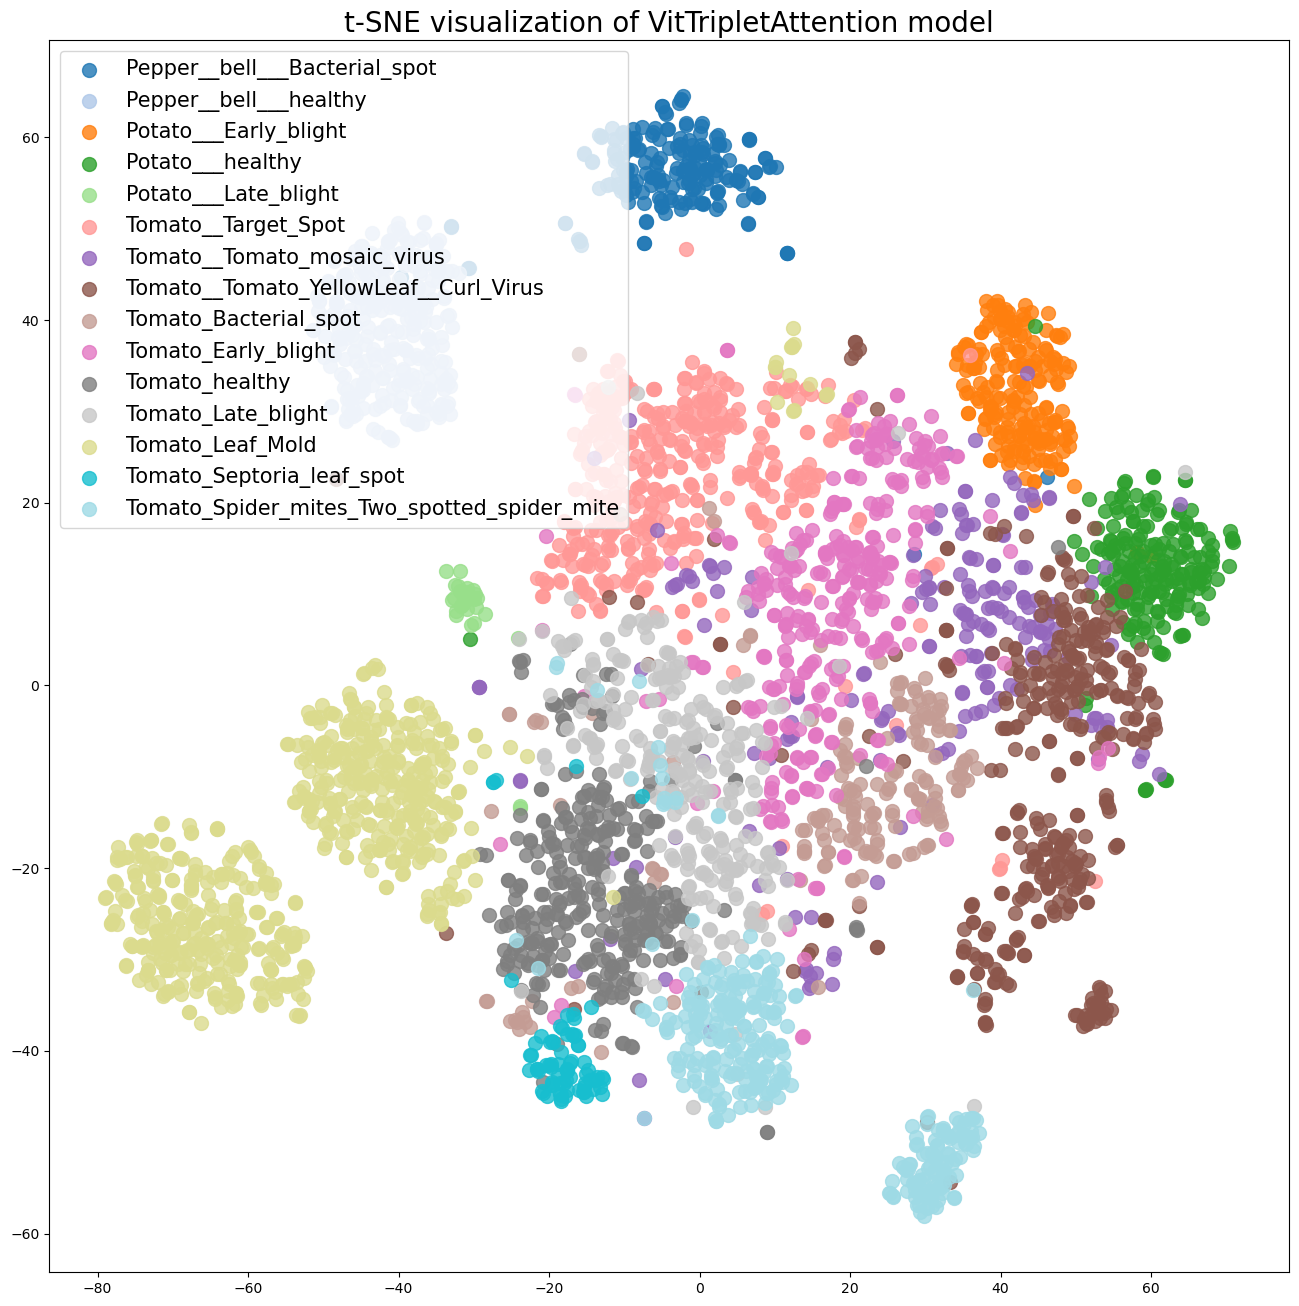

In [4]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def vis_tSNE(model, test_loader, device, backbone='VitTripletAttention'):
    model.eval()  # مدل را در حالت ارزیابی قرار می‌دهیم
    all_embeddings = []
    all_labels = []

    with torch.no_grad():  # بدون محاسبه گرادیان‌ها
        for batch in test_loader:
            # چک کردن تعداد مقادیر برگشتی
            if len(batch) == 4:
                anchor, positive, negative, labels = batch
            elif len(batch) == 3:
                anchor, positive, negative = batch
                labels = np.zeros(anchor.size(0))  # به صورت موقت برچسب‌ها را صفر قرار می‌دهیم
            else:
                continue  # اگر تعداد مقادیر به درستی تنظیم نشده بود، از این بخش عبور می‌کنیم

            # انتقال داده‌ها به دستگاه (GPU یا CPU)
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            labels = torch.tensor(labels).to(device)  # تبدیل برچسب‌ها به tensor و انتقال به دستگاه

            # استخراج ویژگی‌ها (embeddings)
            anchor_features = model.get_embedding(anchor)
            positive_features = model.get_embedding(positive)
            negative_features = model.get_embedding(negative)

            # اضافه کردن ویژگی‌ها و برچسب‌ها
            all_embeddings.append(anchor_features.cpu().numpy())  # می‌توانید فقط ویژگی‌های anchor را در نظر بگیرید
            all_labels.append(labels.cpu().numpy())

    # تبدیل لیست‌های ویژگی‌ها و برچسب‌ها به numpy arrays
    all_embeddings = np.concatenate(all_embeddings, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # بررسی برچسب‌ها
    print(f'Unique labels: {np.unique(all_labels)}')

    # اعمال t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    X_embedded = tsne.fit_transform(all_embeddings)

    # رسم نمودار t-SNE
    plt.figure(figsize=(16, 16))
    
    # انتخاب رنگ‌ها برای هر کلاس
    unique_labels = np.unique(all_labels)
    label_encoder = LabelEncoder()
    label_encoder.fit(all_labels)
    encoded_labels = label_encoder.transform(all_labels)

    # انتخاب رنگ‌های مناسب برای هر کلاس
    colors = plt.cm.get_cmap('tab20', len(unique_labels))  # خودکار انتخاب رنگ‌ها

    # اسامی کلاس‌ها به صورت دستی
    labels_name = ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 
                   'Potato___Late_blight', 'Tomato__Target_Spot', 'Tomato__Tomato_mosaic_virus', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 
                   'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_healthy', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 
                   'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite']

    # رسم نمودارهای پراکندگی برای هر کلاس
    for i, label in enumerate(unique_labels):
        inds = np.where(encoded_labels == i)[0]
        plt.scatter(X_embedded[inds, 0], X_embedded[inds, 1], alpha=.8, color=colors(i), s=100, label=labels_name[i])

    # افزودن افسانه (Legend)
    plt.legend(fontsize=15)
    plt.title(f't-SNE visualization of {backbone} model', fontsize=20)
    
    # ذخیره نمودار به فایل
    plt.savefig(f'./tsne_{backbone}.png')
    plt.show()

# بارگذاری داده‌ها و استفاده از کد
data_dir = 'f:/Meysam-Khodarahi/PlantDiseaseDiagnosisFewShotLearning/siamese_triplet_net/src/dataset_oneshot'
test_dir = os.path.join(data_dir, "test")
test_dataset = ImageFolder(test_dir)

# ایجاد TripletDataset و DataLoader
test_triplet_dataset = TripletDataset(test_dataset)
test_loader = DataLoader(test_triplet_dataset, batch_size=32, shuffle=True)

# فراخوانی تابع
vis_tSNE(model, test_loader, device, backbone='VitTripletAttention')
